# 3-body problem
In this notebook we consider a classical but yet unsolved mathematical challenge. The three body problem as we consider it arose very naturally from the work of Isaac Newton. Upon stating the gravitational law in _'Philosophiæ Naturalis Principia Mathematica'_ Newton turned his attention to systems more complex than a Sun-Planet system. One of his main considerations was the Sun-Earth-Moon system. However, Newton’s work in this regard was plagued by difficulties, and he remarked _“...[his] head never ached but with his studies on the moon”_. It would not be until after Newton’s lifetime that any major progress was made on the three body problem. Many bright minds has attacked the problem: Henri Poincare, Leonhard Euler, Carl Jacobi, Charles Delanay and many others. "The n-body problem - a bulwark against the flow of time, a reliable landmark on the map of mathematics ... it has survived 300 years of siege. It has kindled and witnessed a few revolutions: the beginnings of calculus, of qualitative methods, of relativity, of chaos; tackled numerically, it has contributed to the launch of satellites and to the first human step on the moon. Now it is disturbing the fundamentals of diffrential equations theory" mentions F. Daicu [1]. 

We'll consider the following cases:
- Sun-Earth-jupyter
- Pythagorian problem
- Periodic orbit
- Chaotic orbit
- Kepler-16 star system

The goal would be to understand how what is stability and how chaotic regimes differ from stable ones. 

### References 
1. Florin Diacu. ["The Solution of the n-body Problem"](http://www.math.uvic.ca/faculty/diacu/diacuNbody.pdf), The Mathematical Intelligencer, 1996.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline

In /Users/anaderi/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/anaderi/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/anaderi/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


As with the previous notebook, here we rely on the following motion equations:

$$ \vec{F_1}=\frac{G m_1 m_2}{r_{12}^{3}} \vec{r_{12}} + \frac{G m_1 m_3}{r_{13}^{3}} \vec{r_{13}}$$

where $\vec{r_{ij}}$ is a vector connecting i-th and j-th bodies. So in the differential form we get:

\begin{aligned}
\frac{d^{2} x_1}{d t^{2}}= \frac{G m_2 \left(x_2-x_1\right)}{r_{12}^{3}}  + \frac{G m_3 \left(x_3-x_1\right)}{r_{13}^{3}}  \\
\frac{d^{2} y_1}{d t^{2}}= \frac{G m_2 \left(y_2-y_1\right)}{r_{12}^{3}}  + \frac{G m_3 \left(y_3-y_1\right)}{r_{13}^{3}}  \\
\end{aligned}

and the other four equations can be obtained by cyclic permutations 1 → 2 → 3 → 1

As in the previous notebook we create a first-order equation system that can be written in Python in the following way:

In [116]:
def derivative(X, t, m1, m2, m3, G):
    dXdt = np.zeros_like(X)
    dXdt[:6] = X[6:]

    r12, r13, r23 = X[2:4] - X[0:2], X[4:6] - X[0:2], X[4:6] - X[2:4]
    frac12 = ((r12**2).sum())**-1.5
    frac13 = ((r13**2).sum())**-1.5
    frac23 = ((r23**2).sum())**-1.5

    dXdt[6:8]   =  G*(r12*frac12*m2 + r13*frac13*m3)
    dXdt[8:10]  =  G*(r23*frac23*m3 - r12*frac12*m1)
    dXdt[10:12] = -G*(r13*frac13*m1 + r23*frac23*m2)

    return dXdt

In [119]:
# Let's define different G constants that we'll use for space and mathematical system simulation.
G_phys = 4 * np.pi**2  # For astronomical units
G_math = 1
# Some aux ODE solver params needed for tough (close encounter) cases 
tol  = 1e-9 # determine the error threshold controlled by the solver
hmax = 1e-4 # max size of the step taken by solver

### Sun - Earth - Jupyter system

In [128]:
mSun_si = 1.9885e30
mEarth_si = 5.972e24
mJup_si = 1.898e27

m1, m2, m3 = mSun_si/mSun_si, mEarth_si/mSun_si, mJup_si/mSun_si

x0 = [0.0, 0.0] + [1.0, 0.0] + [-5.2, 0.0]
v0 = [0.0, 0.0] + [0.0, 6.283] + [0.0, -2.89] 
X0 = np.array(x0 + v0)

t = np.linspace(0, 60, 30001)

In [137]:
%%time
solution_sej = odeint(derivative, X0, t, args=(m1, m2, m3, G_phys))

CPU times: user 579 ms, sys: 6.89 ms, total: 586 ms
Wall time: 582 ms


In [140]:
# Let's define some plotting routines
def get_color(i):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    return colors[i]

def plot_solution(solution, t, xlim=(-6, 6), ylim=(-4, 4), labels=['Body-1', 'Body-2', 'Body-3']):
    xy3, xy4, xy5 = solution.T[:6].reshape(3,2,-1)
    paths         = [xy3, xy4, xy5]
    plt.figure(figsize=(8,10), dpi=100)
    plt.subplot(2, 1, 1)
    for i, (x, y) in enumerate(paths):
        plt.plot(x, y, alpha=0.4)
    for i, (x, y) in enumerate(paths):
        plt.plot(x[:1], y[:1], 'o', color=get_color(i), label=labels[i])
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("3-body XY phase space")
    plt.legend()
    
    plt.subplot(4,1,3)
    for x, y in paths:
        plt.plot(t, x)
    plt.ylim(xlim)
    plt.ylabel('x')
    plt.subplot(4,1,4)
    for x, y in paths:
        plt.plot(t, y)
    plt.ylim(ylim)
    plt.ylabel('y')
    plt.xlabel('time')

    plt.show()

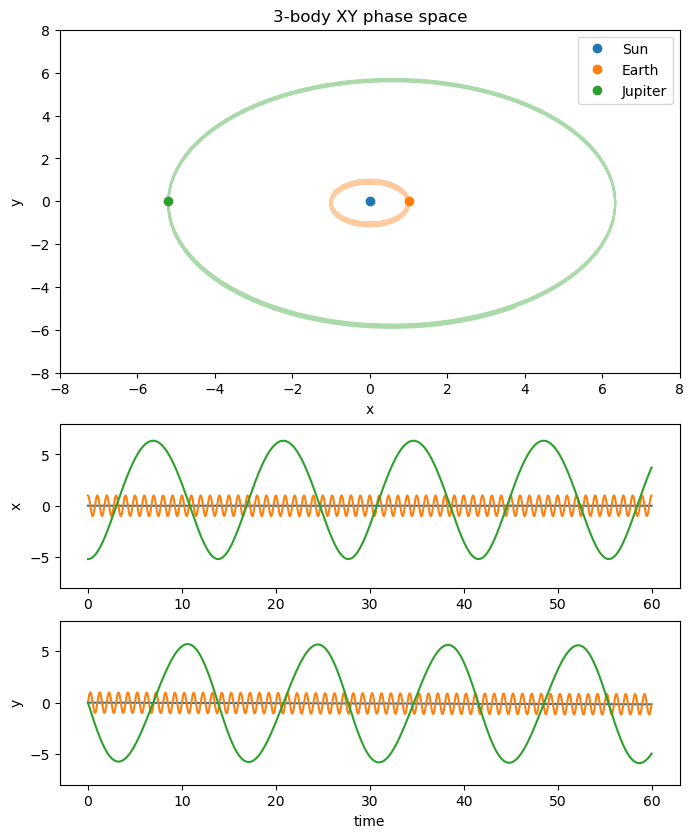

In [141]:
plot_solution(solution_sej, t, xlim=(-8, 8), ylim=(-8, 8), labels=['Sun', 'Earth', 'Jupiter'])

## Pythoagorian Three Body Problem
The Pythagorean Three Body Problem ([wiki](https://en.wikipedia.org/wiki/Three-body_problem#Additional_solutions)) also know as [Burrau's problem](http://www.ucolick.org/~laugh/oxide/projects/burrau.html) is a special case of the general three body problem, where the the three bodies have masses of 3, 4, and 5, and the initial conditions are such that they begin at rest, at the vertices of a 3-4-5 right triangle.
<img src="https://i.stack.imgur.com/hMVAj.png">
<img src="https://i.stack.imgur.com/WWKOs.png">

Discussion of accuracy of odeint solver at [stackoverflow](https://space.stackexchange.com/questions/15364/pythagorean-three-body-problem-need-some-points-from-an-accurate-solution-fo/15369#15369).

PS more generic problem of n-body interaction http://www.math.uvic.ca/faculty/diacu/diacuNbody.pdf

In [99]:
# Pythagorean Three Body Problem
m1, m2, m3 = 3.0, 4.0, 5.0


x0 = [1.0, 3.0] + [-2.0, -1.0] + [1.0, -1.0]
v0 = [0.0, 0.0] + [ 0.0,  0.0] + [0.0,  0.0] 
X0 = np.array(x0 + v0)

t = np.linspace(0, 60,  60001)

In [100]:
%%time
solution_pyth, info = odeint(derivative, X0, t, args=(m1, m2, m3, G_math), rtol=tol, atol=tol,
                      hmax=hmax, full_output=True)

CPU times: user 1min 3s, sys: 239 ms, total: 1min 3s
Wall time: 1min 3s


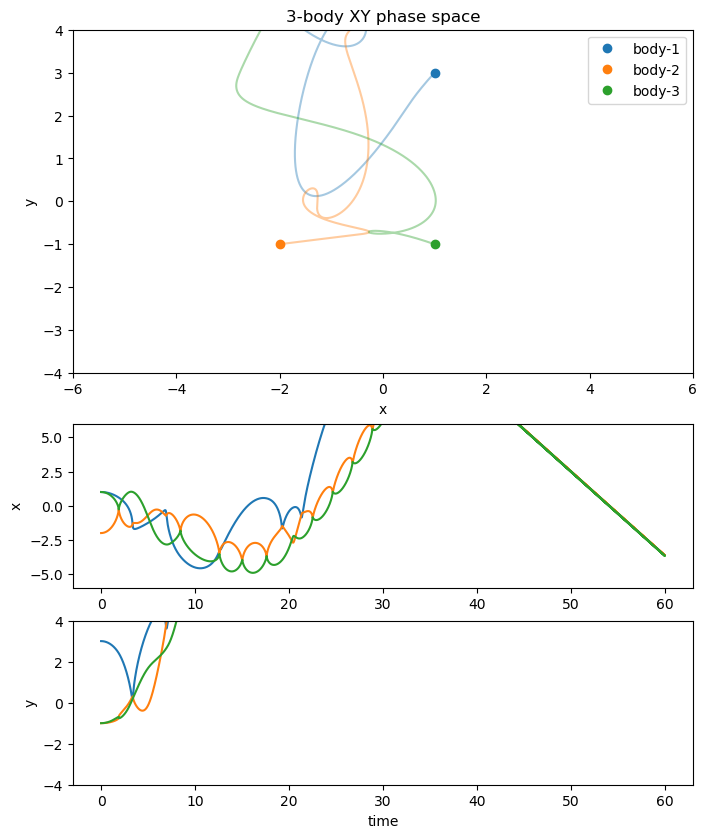

In [105]:
plot_solution(solution_pyth, t)

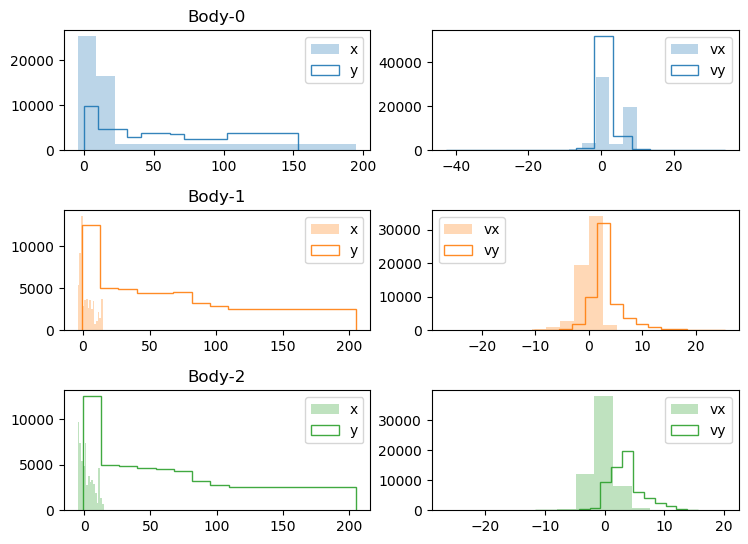

In [106]:
plot_histograms(solution_pyth)

## Periodic solutions


https://arxiv.org/pdf/math/0011268.pdf

In [142]:
# 8-cycle
m1, m2, m3 = 1.0, 1.0, 1.0


x0 = [-0.97000436, 0.24308753] + [0.97000436, -0.24308753] + [0.0, 0.0]
v0 = [ 0.93240737/2, 0.86473146/2] + [ 0.93240737/2, 0.86473146/2] + [-0.93240737, -0.86473146] 
X0 = np.array(x0 + v0)

t = np.linspace(0, 10,  6001)

In [143]:
%%time
solution_8 = odeint(derivative, X0, t, args=(m3, m4, m5, G_math))

CPU times: user 46.1 ms, sys: 5.92 ms, total: 52 ms
Wall time: 47.6 ms


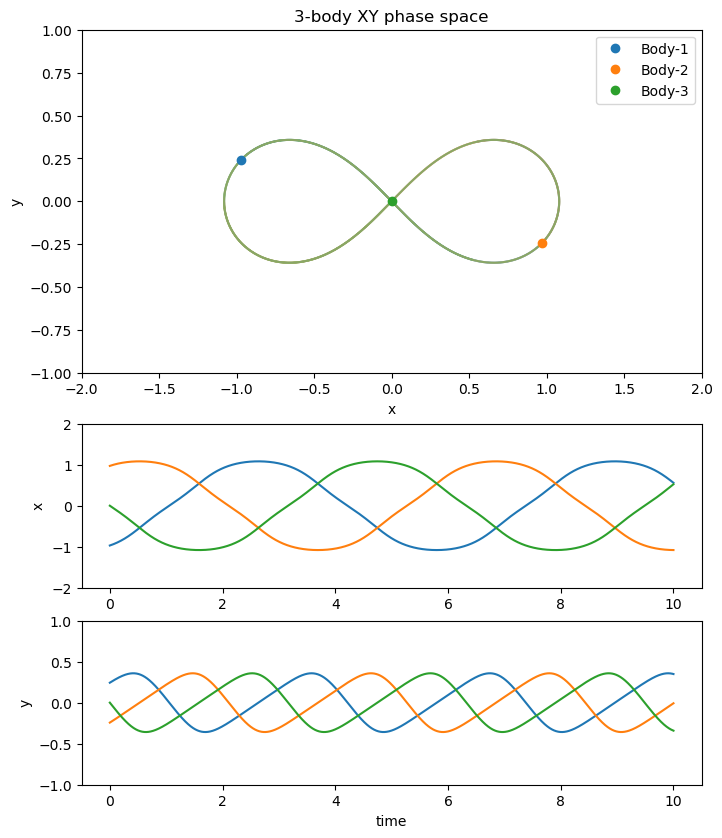

In [145]:
plot_solution(solution_8, t, xlim=(-2, 2), ylim=(-1, 1))

In [148]:
def plot_histograms(solution):
    xy1, xy2, xy3 = solution.T[:6].reshape(3,2,-1)
    v1, v2, v3    = solution.T[6:12].reshape(3,2,-1)
    paths         = [xy1, xy2, xy3]
    speed         = [v1, v2, v3]
    plt.figure(figsize=(10,6), dpi=100)
    bins=15
    
    for i, (x, y) in enumerate(paths):
        c = get_color(i)
        plt.subplot(3, 2, 2*i + 1, title="Body-{}".format(i + 1))
        plt.hist(x, bins=bins, label='x', alpha=0.3, color=c)
        plt.hist(y, bins=bins, label='y', alpha=0.9, histtype='step', color=c)
        plt.legend()
     
    for i, (vx, vy) in enumerate(speed):
        c = get_color(i)
        plt.subplot(3, 2, 2*i + 2)
        plt.hist(vx, bins=bins, label='vx', alpha=0.3, color=c)
        plt.hist(vy, bins=bins, label='vy', alpha=0.9, histtype='step', color=c)
        plt.legend()
        
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5)
    plt.show()

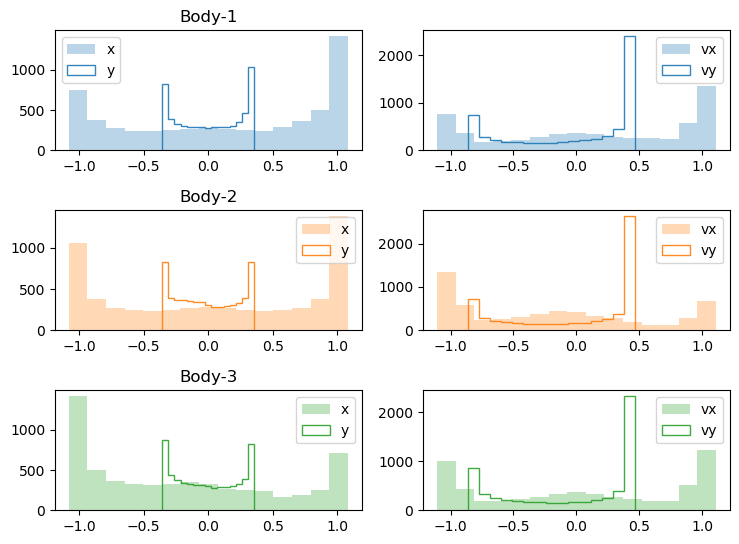

In [150]:
plot_histograms(solution_8)

### Further into the space
Kepler-16 system: binary star (AB) and a planet (b):
http://exoplanet.eu/catalog/kepler-16_%28ab%29_b/

Kepler-16 has been dubbed as Tatooine (from Star Wars universe), due to the double sunset
<img src="https://i.imgur.com/HYA25rgl.jpg"> 
Image taken from https://www.cosmosup.com/tatooine-like-planets-with-twin-sunsets-may-be-common-in-universe/

In [260]:
def speed_si2au(v): return 6.283/29.8*v
def speed_au2si(v): return 29.8/6.283*v

m1, m2, m3 = 0.654, 0.1959, 0.3333 * mJup_si/mSun_si

x0 = [(m2 * 0.224)/(m1 + m2), 0.0] +   \
     [-(m1 * 0.224)/(m1 + m2), 0.0] + \
     [0.7048, 0.0]
v0 = [0.0, 2*np.pi*x0[0]/(41/365.25)] + \
     [0.0, 2*np.pi*x0[2]/(41/365.25)] + \
     [0.0, 2*np.pi*x0[4]/(228/365.25)]
X0 = np.array(x0 + v0)

t = np.linspace(0, 10,  10001)
G = 4 * np.pi**2

In [258]:
%%time 
solution_kepler16 = odeint(derivative, X0, t, rtol=tol, atol=tol, args=(m1, m2, m3, G_space))

CPU times: user 614 ms, sys: 5.59 ms, total: 620 ms
Wall time: 618 ms


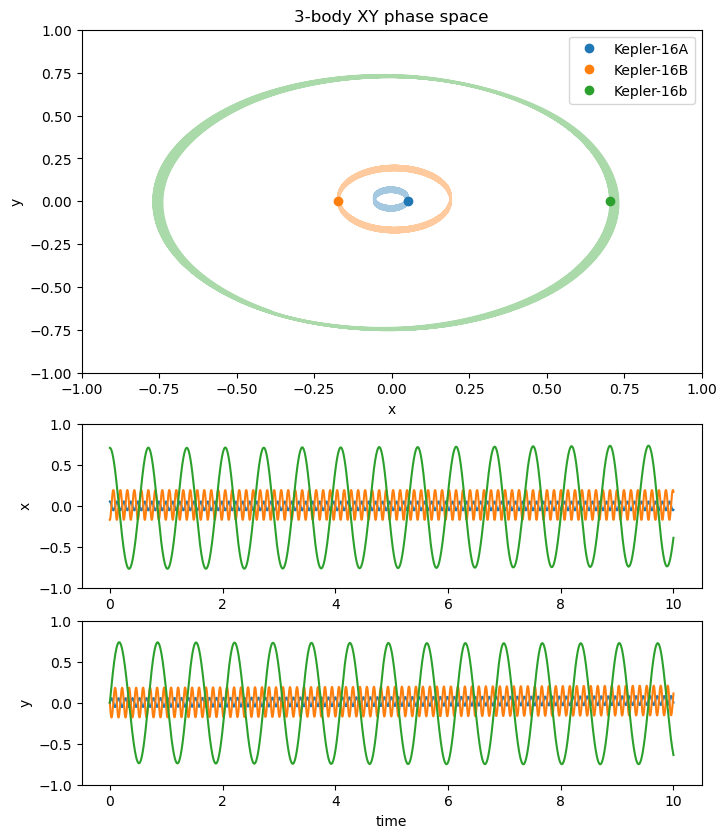

In [259]:
plot_solution(solution_kepler16, t, xlim=(-1,1), ylim=(-1,1), labels=['Kepler-16A', 'Kepler-16B', 'Kepler-16b'])

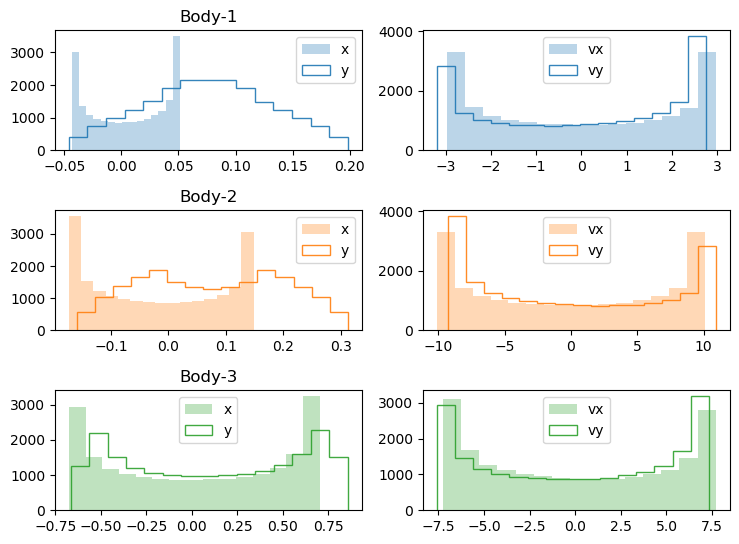

In [186]:
plot_histograms(solution_kepler16)

## Chaotic motion

In [214]:
# from polar to cartesian transform
def p2c(r, theta):
    return [r*np.cos(theta), r*np.sin(theta)]

m1, m2, m3 = 1, 1, 1

x0 = [1.0, 0.0] + [-0.4999999999999998, 0.866025] + [-0.5000000000000004, -0.8660254037844384]
v0 = [3.367778697655222e-17, 0.55] + \
    [-0.4763139720814414, -0.2749999999999999] + \
    [0.47631397208144116, -0.27500000000000024]
X0 = np.array(x0 + v0)

t = np.linspace(0, 60,  60001)

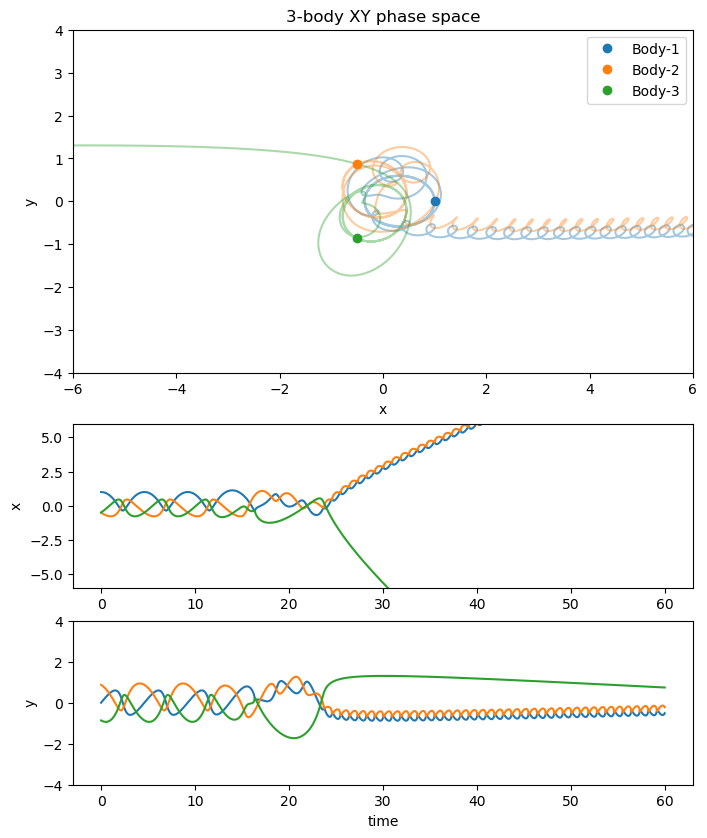

CPU times: user 32.3 s, sys: 290 ms, total: 32.6 s
Wall time: 34 s


In [179]:
%%time 
solution_chaos, _ = odeint(derivative, X0, t, args=(m1, m2, m3, G_math), rtol=tol, atol=tol, hmax=hmax, full_output=True)
plot_solution(solution_chaos, t)

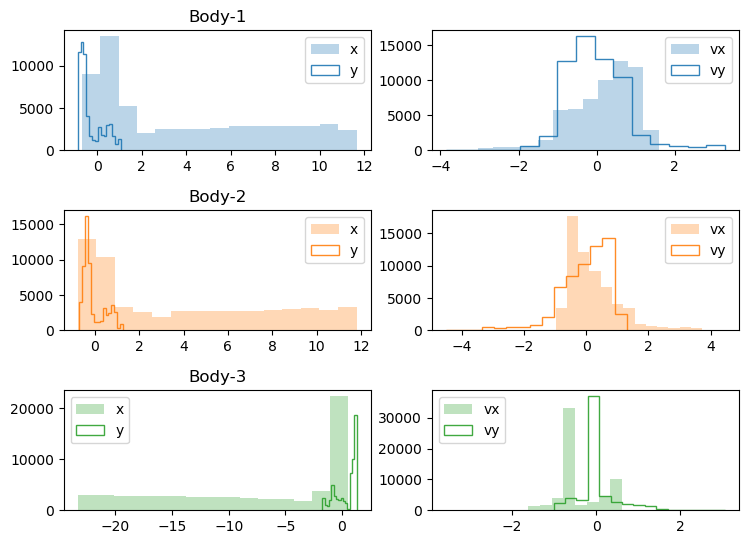

In [180]:
plot_histograms(solution_chaos)

In [224]:
X0_mod = X0
X0_mod[0] = X0[0] * (1+1e-7)
X0_mod

array([ 1.00000012e+00,  0.00000000e+00, -5.00000000e-01,  8.66025000e-01,
       -5.00000000e-01, -8.66025404e-01,  3.36777870e-17,  5.50000000e-01,
       -4.76313972e-01, -2.75000000e-01,  4.76313972e-01, -2.75000000e-01])

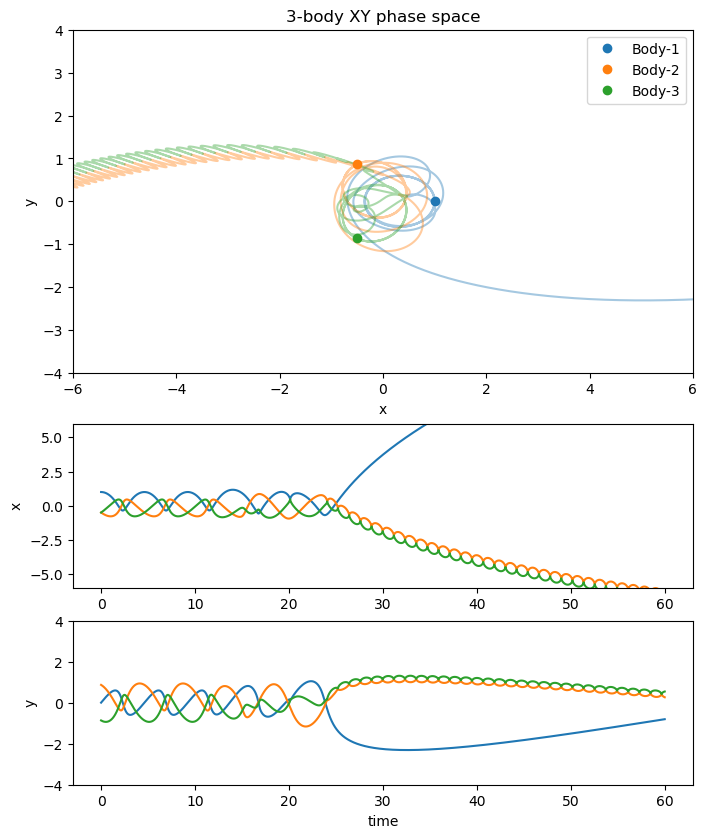

CPU times: user 33.2 s, sys: 225 ms, total: 33.4 s
Wall time: 33.8 s


In [225]:
%%time 
solution_chaos, _ = odeint(derivative, X0_mod, t, args=(m1, m2, m3, G_math), rtol=tol, atol=tol, hmax=hmax,  full_output=True)
plot_solution(solution_chaos, t)

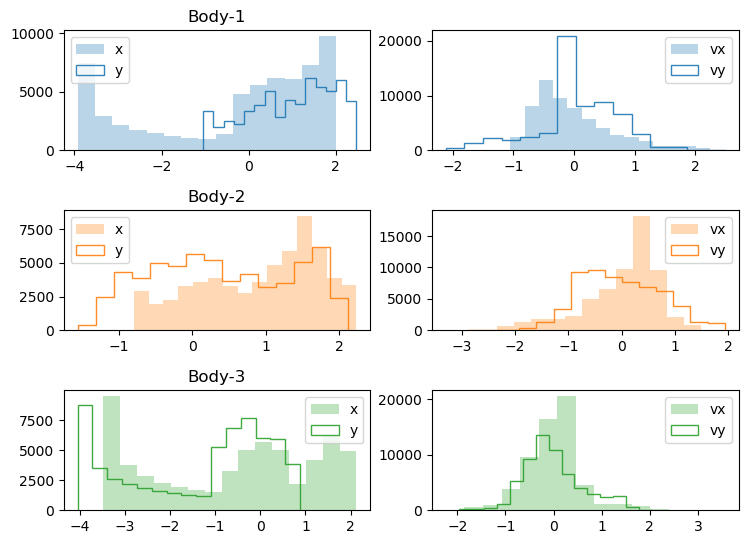

In [184]:
plot_histograms(solution_chaos)

More details of different 3-body configurations
http://butikov.faculty.ifmo.ru/Projects/Collection.html#_contents

### Task: What is the biggest change you can make to $X_0$ so the behaviour of the system will be indistinguishable by the naked eye from the original during the first 20-th time ticks?